# 【問題1】公式チュートリアルモデルを分担して実行¶
TensorFLowの公式チュートリアルモデルを分担して実行してください。

以下の中から1人ひとつ選び実行し、その結果を簡単に発表してください。

models/tutorials at master · tensorflow/models

##### Copyright 2018 The TensorFlow Authors.


In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Image captioning with visual attention

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/text/image_captioning">
    <img src="https://www.tensorflow.org/images/tf_logo_32px.png" />
    View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/text/image_captioning.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/text/image_captioning.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/text/image_captioning.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

Given an image like the example below, our goal is to generate a caption such as "a surfer riding on a wave".

![Man Surfing](https://tensorflow.org/images/surf.jpg)

*[Image Source](https://commons.wikimedia.org/wiki/Surfing#/media/File:Surfing_in_Hawaii.jpg); License: Public Domain*

To accomplish this, you'll use an attention-based model, which enables us to see what parts of the image the model focuses on as it generates a caption.

![Prediction](https://tensorflow.org/images/imcap_prediction.png)

The model architecture is similar to [Show, Attend and Tell: Neural Image Caption Generation with Visual Attention](https://arxiv.org/abs/1502.03044).

This notebook is an end-to-end example. When you run the notebook, it downloads the [MS-COCO](http://cocodataset.org/#home) dataset, preprocesses and caches a subset of images using Inception V3, trains an encoder-decoder model, and generates captions on new images using the trained model.

In this example, you will train a model on a relatively small amount of data—the first 30,000 captions  for about 20,000 images (because there are multiple captions per image in the dataset).

In [105]:
import tensorflow as tf

# You'll generate plots of attention in order to see which parts of an image
# our model focuses on during captioning
import matplotlib.pyplot as plt

# Scikit-learn includes many helpful utilities
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import re
import numpy as np
import os
import time
import json  #JavaScript 言語の表記法をベースにしたデータ形式
from glob import glob  #ワイルドカード*などの特殊文字を使って条件を満たすファイル名・ディレクトリ（フォルダ）名などのパスの一覧をリストやイテレータで取得できる
from PIL import Image  #画像処理ライブラリ。リサイズ（拡大・縮小）や回転、トリミング（部分切り出し）のような単純な処理はバッチリ。
import pickle

## Download and prepare the MS-COCO dataset

You will use the [MS-COCO dataset](http://cocodataset.org/#home) to train our model. The dataset contains over 82,000 images, each of which has at least 5 different caption annotations. The code below downloads and extracts the dataset automatically.

**Caution: large download ahead**. You'll use the training set, which is a 13GB file.

In [3]:
# Download caption annotation files
annotation_folder = '/annotations/'
if not os.path.exists(os.path.abspath('.') + annotation_folder):
  annotation_zip = tf.keras.utils.get_file('captions.zip',
                                          cache_subdir=os.path.abspath('.'),
                                          origin = 'http://images.cocodataset.org/annotations/annotations_trainval2014.zip',
                                          extract = True)
  annotation_file = os.path.dirname(annotation_zip)+'/annotations/captions_train2014.json'
  os.remove(annotation_zip)

  #tf.keras.utils.get_file: ファイルがまだキャッシュにない場合は、URLからファイルをダウンロードします。

# Download image files
image_folder = '/train2014/'
if not os.path.exists(os.path.abspath('.') + image_folder):
  image_zip = tf.keras.utils.get_file('train2014.zip',
                                      cache_subdir=os.path.abspath('.'),
                                      origin = 'http://images.cocodataset.org/zips/train2014.zip',
                                      extract = True)
  PATH = os.path.dirname(image_zip) + image_folder
  os.remove(image_zip)
else:
  PATH = os.path.abspath('.') + image_folder

13510574080/13510573713 [==============================] - 328s 0us/step


## Optional: limit the size of the training set 
To speed up training for this tutorial, you'll use a subset of 30,000 captions and their corresponding images to train our model. Choosing to use more data would result in improved captioning quality.

In [4]:
# Read the json file
with open(annotation_file, 'r') as f:  #読み込み専用としてファイルを開く
    annotations = json.load(f)

# Store captions and image names in vectors　　＃キャプションと画像名をリストに保存する
all_captions = []
all_img_name_vector = []

for annot in annotations['annotations']:
    caption = '<start> ' + annot['caption'] + ' <end>'
    image_id = annot['image_id']
    full_coco_image_path = PATH + 'COCO_train2014_' + '%012d.jpg' % (image_id)

    all_img_name_vector.append(full_coco_image_path)
    all_captions.append(caption)

# Shuffle captions and image_names together
# Set a random state
train_captions, img_name_vector = shuffle(all_captions,
                                          all_img_name_vector,
                                          random_state=1)

# Select the first 30000 captions from the shuffled set
num_examples = 30000
train_captions = train_captions[:num_examples]
img_name_vector = img_name_vector[:num_examples]

In [5]:
len(train_captions), len(all_captions)

(30000, 414113)

## 画像の前処理

## Preprocess the images using InceptionV3
Next, you will use InceptionV3 (which is pretrained on Imagenet) to classify each image. You will extract features from the last convolutional layer.

説明<br>
Inception-v3 は、ImageNet データベース [1] の 100 万枚を超えるイメージで学習済みの畳み込みニューラル ネットワークです。このネットワークは、深さが 48 層であり、イメージを 1000 個のオブジェクト カテゴリ (キーボード、マウス、鉛筆、多くの動物など) に分類できます。結果として、このネットワークは広範囲のイメージに対する豊富な特徴表現を学習しています。ネットワークのイメージ入力サイズは 299 x 299 です。

First, you will convert the images into InceptionV3's expected format by:
* Resizing the image to 299px by 299px
* [Preprocess the images](https://cloud.google.com/tpu/docs/inception-v3-advanced#preprocessing_stage) using the [preprocess_input](https://www.tensorflow.org/api_docs/python/tf/keras/applications/inception_v3/preprocess_input) method to normalize the image so that it contains pixels in the range of -1 to 1, which matches the format of the images used to train InceptionV3.

In [6]:
def load_image(image_path):
    img = tf.io.read_file(image_path)  #画像ファイル読み込み
    img = tf.image.decode_jpeg(img, channels=3)  #jpegをuint8テンソルにデコード
    img = tf.image.resize(img, (299, 299))  #rサイズ変更
    img = tf.keras.applications.inception_v3.preprocess_input(img)  #前処理、-1〜1の範囲のピクセルが含まれるように画像を正規化
    return img, image_path

## Initialize InceptionV3 and load the pretrained Imagenet weights

Now you'll create a tf.keras model where the output layer is the last convolutional layer in the InceptionV3 architecture. The shape of the output of this layer is ```8x8x2048```. You use the last convolutional layer because you are using attention in this example. You don't perform this initialization during training because it could become a bottleneck.

* You forward each image through the network and store the resulting vector in a dictionary (image_name --> feature_vector).
* After all the images are passed through the network, you pickle the dictionary and save it to disk.


In [7]:
image_model = tf.keras.applications.InceptionV3(include_top=False,
                                                weights='imagenet')  #Inception v3をインスタンス化、最後の層に全結合層は含めない

new_input = image_model.input  #グループ化する為の処理
hidden_layer = image_model.layers[-1].output  #グループ化する為の処理。　最後の層を出力層にしている？

#Model レイヤーをトレーニングおよび推論機能を備えたオブジェクトにグループ化します。最終的なモデルインスタンス化。引数：（input, output）
image_features_extract_model = tf.keras.Model(new_input, hidden_layer)  

87916544/87910968 [==============================] - 1s 0us/step


## Caching the features extracted from InceptionV3

You will pre-process each image with InceptionV3 and cache the output to disk. Caching the output in RAM would be faster but also memory intensive, requiring 8 \* 8 \* 2048 floats per image. At the time of writing, this exceeds the memory limitations of Colab (currently 12GB of memory).

Performance could be improved with a more sophisticated caching strategy (for example, by sharding the images to reduce random access disk I/O), but that would require more code.

The caching will take about 10 minutes to run in Colab with a GPU. If you'd like to see a progress bar, you can: 


InceptionV3から抽出された機能のキャッシュ<br>
各画像をInceptionV3で前処理し、出力をディスクにキャッシュします。RAMでの出力のキャッシュは高速ですが、メモリを大量に消費するため、画像ごとに8 * 8 * 2048の浮動小数点数が必要です。執筆時点では、これはColabのメモリ制限（現在は12GBのメモリ）を超えています。<br>

より高度なキャッシュ戦略（たとえば、イメージをシャーディングしてランダムアクセスディスクI / Oを削減する）を使用すると、パフォーマンスを向上させることができますが、そのためにはより多くのコードが必要になります<br>

キャッシュは、GPUを使用するColabで実行するのに約10分かかります。進行状況バーを表示したい場合は、次のことができます。<br>


1. install [tqdm](https://github.com/tqdm/tqdm):

    `!pip install tqdm`

2. Import tqdm:

    `from tqdm import tqdm`

3. Change the following line:

    `for img, path in image_dataset:`

    to:

    `for img, path in tqdm(image_dataset):`


パフォーマンスを最適化する
(GPU と TPU のような) 新しい計算デバイスがニューラルネットワークをどんどん高速に訓練することを可能にしますので、CPU 処理がボトルネックになりがちです。tf.data API は CPU を効果的に利用して ETL プロセスの各ステップを最適化する入力パイプラインを設計するためのビルディングブロックをユーザに提供します。

パイプライン処理
訓練ステップを遂行するためには、最初に訓練データを抽出して変換してそれからそれをアクセラレータで動作するモデルに供給しなければなりません。けれども、素朴な同期実装では、CPU がデータを準備している間、アクセラレータはアイドリングしています。反対に、アクセラレータがモデルを訓練している間、CPU はアイドリングしています。こうして訓練ステップ時間は CPU 前処理時間とアクセラレータ訓練時間の両者の総計です。

パイプライン処理 は前処理と訓練ステップのモデル実行をオーバーラップさせます。アクセラレータが訓練ステップ N を遂行している間、CPU はステップ N+1 のためのデータを準備しています。そのようにすることはステップ時間を訓練とデータを抽出して変換するのにかかる時間の (総計と対照的に) 最大値にまで減じます。

パイプライン処理なしでは、CPU と GPU/TPU は殆どの時間アイドリングします :

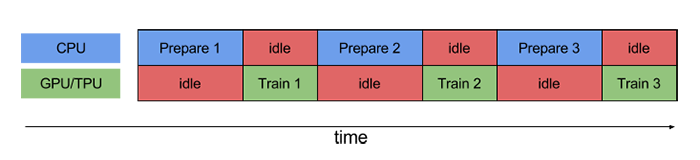

パイプライン処理では、アイドル時間は著しく減少します :

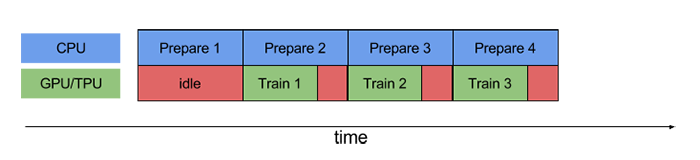


tf.data API は tf.data.Dataset.prefetch 変換を通してソフトウェア・パイプライン処理機構を提供します、これはデータが生成される時をデータが消費される時から切り離します。特に、変換は要求される前に入力データセットから要素を先取りする (= prefetch) ためにバックグラウンド・スレッドと内部バッファを使用します。先取りする要素の数は単一の訓練ステップにより消費されるバッチの数と同じ (あるいは多分それ以上) であるべきです。この値を手動で調整するかそれを tf.data.experimental.AUTOTUNE に設定することもできるでしょう、これは tf.data ランタイムに実行時に動的に値を調整することを促します、

この変更を私達の実行サンプルに適用するためには、次を :

dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
貴方の入力パイプラインの最後の変換として挿入します。

prefetech 変換は “producer” のワークを “consumer” のワークとオーバーラップさせる機会があればいつでも利益をもたらすことに注意してください。


データ変換を並列化する
バッチを準備するとき、入力要素は前処理される必要があるかもしれません。この目的のために、tf.data API は tf.data.Dataset.map 変換を提供します、これは入力データセットの各要素にユーザ定義関数 (例えば、実行サンプルからの parse_fn) を適用します。入力要素は互いに無関係なので、前処理はマルチ CPU コアに渡り並列化できます。これを可能にするために、map 変換は並列処理のレベルを指定する num_parallel_calls 引数を提供します。例えば、次の図は map 変換に num_parallel_calls=2 を設定する効果を示します :

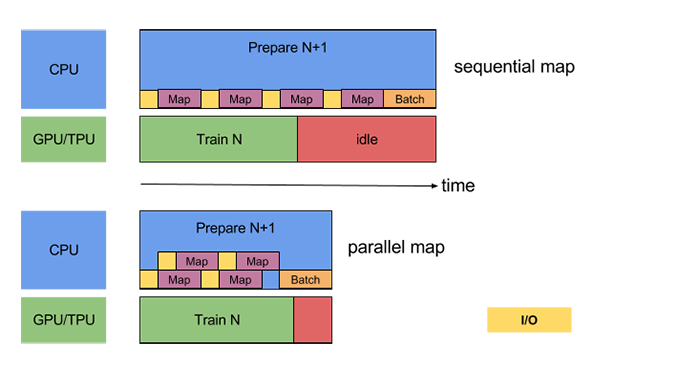


num_parallel_calls 引数のための最善の値を選択することはハードウェア、(サイズと shape のような) 訓練データの特性、map 関数のコスト、そして何の他の処理が同時に CPU 上で起きているかに依拠します ; 単純な経験則は利用可能な CPU コアの数を使用します。例えば、上のサンプルを実行するマシンが 4 コアを持つ場合、それは num_parallel_calls=4 を設定することはより効率的でしょう。その一方で、num_parallel_calls を利用可能な CPU の数よりも遥かに大きい値に設定すると非効率的なスケジューリングに繋がり、スローダウンの結果になる可能性があります。prefetch 変換と同様に、map 変換は tf.data.experimental.AUTOTUNE をサポートします、これはどのレベルの並列処理を使用するかについての決定を tf.data ランタイムに委ねます。

実行サンプルにこの変更を適用するには、次を :

dataset = dataset.map(map_func=parse_fn)
次で置き換えます :

dataset = dataset.map(map_func=parse_fn, num_parallel_calls=tf.data.experimental.AUTOTUNE)
＃マルチコアCPU使用時の並列処理数を設定できる。。ということかと。。





In [8]:
# Get unique images
encode_train = sorted(set(img_name_vector))

# Feel free to change batch_size according to your system configuration    システム構成に応じて、batch_sizeを自由に変更してください。
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)  #データセット作成
image_dataset = image_dataset.map(
  load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(16)  #load_image(画像を読みこむ関数)を、.mapで要素全てに適用。num_parallel_calls：非同期で並列処理する要素数。 
                                                                               #tf.data.experimental:入力パイプラインを構築するための実験的なAPI。
for img, path in image_dataset:
  batch_features = image_features_extract_model(img)
  batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))

  for bf, p in zip(batch_features, path):
    path_of_feature = p.numpy().decode("utf-8")  # .numpy() メソッドを使って明示的に NumPy の ndarray に変換
    np.save(path_of_feature, bf.numpy())  #一つのndarrayをnpyで保存: np.save()

## キャプションの前処理とトークン化

## Preprocess and tokenize the captions

トークン化<br>
1つの文章から段落、段落から文、文から単語へとスコープを変化させつつ意味のある塊に分割する。

* First, you'll tokenize the captions (for example, by splitting on spaces). This gives us a  vocabulary of all of the unique words in the data (for example, "surfing", "football", and so on).
* Next, you'll limit the vocabulary size to the top 5,000 words (to save memory). You'll replace all other words with the token "UNK" (unknown).
* You then create word-to-index and index-to-word mappings.
* Finally, you pad all sequences to be the same length as the longest one.

最初に、キャプションをトークン化します（たとえば、スペースで分割する）。これにより、データ内のすべての一意の単語のボキャブラリが提供されます（たとえば、「サーフィン」、「フットボール」など）。<br>
次に、語彙のサイズを上位5,000ワードに制限します（メモリを節約するため）。他のすべての単語をトークン「UNK」（不明）に置き換えます。<br>
次に、単語とインデックス、およびインデックスと単語のマッピングを作成します。<br>
最後に、すべてのシーケンスに最長のものと同じ長さになるようにパディングします。

In [9]:
# Find the maximum length of any caption in our dataset
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

In [10]:
# Choose the top 5000 words from the vocabulary
top_k = 5000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')  #oov_token：他の単語をunkに置き換える
tokenizer.fit_on_texts(train_captions)  #テキストのリストに基づいて内部の語彙を更新します。
train_seqs = tokenizer.texts_to_sequences(train_captions)  #テキスト内の各テキストを一連の整数に変換します。

In [11]:
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

In [12]:
# Create the tokenized vectors
train_seqs = tokenizer.texts_to_sequences(train_captions) #テキスト内の各テキストを一連の整数に変換します。

In [13]:
# Pad each vector to the max_length of the captions  ＃各ベクトルをキャプションのmax_lengthにパディングします
# If you do not provide a max_length value, pad_sequences calculates it automatically  ＃max_length値を指定しない場合、pad_sequencesはそれを自動的に計算します
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

In [14]:
# Calculates the max_length, which is used to store the attention weights  ＃注意の重みを格納するために使用されるmax_lengthを計算します
max_length = calc_max_length(train_seqs)

## Split the data into training and testing

In [15]:
# Create training and validation sets using an 80-20 split
img_name_train, img_name_val, cap_train, cap_val = train_test_split(img_name_vector,
                                                                    cap_vector,
                                                                    test_size=0.2,
                                                                    random_state=0)

In [16]:
len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

(24000, 24000, 6000, 6000)

## Create a tf.data dataset for training


 Our images and captions are ready! Next, let's create a tf.data dataset to use for training our model.

In [17]:
# Feel free to change these parameters according to your system's configuration
# ＃システムの構成に応じて、これらのパラメーターを自由に変更してください

BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
vocab_size = top_k + 1
num_steps = len(img_name_train) // BATCH_SIZE
# Shape of the vector extracted from InceptionV3 is (64, 2048)  ＃InceptionV3から抽出されたベクトルの形状は（64、2048）
# These two variables represent that vector shape  ＃これら2つの変数はそのベクトル形状を表します
features_shape = 2048
attention_features_shape = 64

In [18]:
# Load the numpy files
def map_func(img_name, cap):
  img_tensor = np.load(img_name.decode('utf-8')+'.npy')
  return img_tensor, cap

In [19]:
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# Use map to load the numpy files in parallel  #マップを使用してnumpyファイルを並列にロードします
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Shuffle and batch  #シャッフルとバッチ
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE) #データセットの要素をランダムにシャッフルし、バッチを作成。バッファをbuffer_size要素で満たし、次にこのバッファから要素をランダムにサンプリングし、選択された要素を新しい要素で置き換えます。完全なシャッフルには、データセットのフルサイズ以上のバッファーサイズが必要です。
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE) #データセットから要素をプリフェッチするデータセットを作成します。プリフェッチ (prefetch) とは、コンピュータにおいて、利用が予測されるデータをあらかじめより高速なメモリに読み込んでおき、性能と速度の向上を図る動作である。日本語では事前読込み（じぜんよみこみ）という。

## Model

Fun fact: the decoder below is identical to the one in the example for [Neural Machine Translation with Attention](../sequences/nmt_with_attention.ipynb).

The model architecture is inspired by the [Show, Attend and Tell](https://arxiv.org/pdf/1502.03044.pdf) paper.

* In this example, you extract the features from the lower convolutional layer of InceptionV3 giving us a vector of shape (8, 8, 2048).<br>
この例では、InceptionV3の下位たたみ込み層から特徴を抽出し、形状のベクトル（8、8、2048）を提供します。
* You squash that to a shape of (64, 2048).<br>
これを（64、2048）の形につぶします。
* This vector is then passed through the CNN Encoder (which consists of a single Fully connected layer).<br>
このベクトルは、CNNエンコーダー（単一の完全に接続されたレイヤーで構成される）を通過します。
* The RNN (here GRU) attends over the image to predict the next word.<br>
RNN（ここではGRU）が画像に参加して、次の単語を予測します。

Modelクラスをサブクラス化する：その場合、レイヤーを定義し__init__、callの中でモデルのフォワードパスを実装する必要があります。

In [20]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):
    # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

    # hidden shape == (batch_size, hidden_size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    # score shape == (batch_size, 64, hidden_size)
    score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))

    # attention_weights shape == (batch_size, 64, 1)
    # you get 1 at the last axis because you are applying score to self.V
    attention_weights = tf.nn.softmax(self.V(score), axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [21]:
class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it using pickle
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [22]:
class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(vocab_size)

    self.attention = BahdanauAttention(self.units)

  def call(self, x, features, hidden):
    # defining attention as a separate model
    context_vector, attention_weights = self.attention(features, hidden)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # shape == (batch_size, max_length, hidden_size)
    x = self.fc1(output)

    # x shape == (batch_size * max_length, hidden_size)
    x = tf.reshape(x, (-1, x.shape[2]))

    # output shape == (batch_size * max_length, vocab)
    x = self.fc2(x)

    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))

In [23]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

In [24]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')  #ラベルと予測の間のクロスエントロピー損失を計算します。

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

## Checkpoint

訓練の間に定期的にパラメータ値をセーブするために TensorFlow チェックポイントが利用できます。これは、貴方のプログラムがクラッシュするか停止する場合に訓練の進捗をセーブするために有用であり得ます。Sonnet は TensorFlow チェックポイントとともにきれいに動作するように設計されています

In [25]:
checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [26]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
  # restoring the latest checkpoint in checkpoint_path #checkpoint_pathの最新のチェックポイントを復元する
  ckpt.restore(ckpt_manager.latest_checkpoint)

## Training

* You extract the features stored in the respective `.npy` files and then pass those features through the encoder.<br>
それぞれの.npyファイルに保存されている機能を抽出し、それらの機能をエンコーダーに渡します。
* The encoder output, hidden state(initialized to 0) and the decoder input (which is the start token) is passed to the decoder.<br>
エンコーダー出力、非表示状態（0に初期化）、およびデコーダー入力（開始トークン）がデコーダーに渡されます。
* The decoder returns the predictions and the decoder hidden state.<br>
デコーダーは予測とデコーダーの非表示状態を返します。
* The decoder hidden state is then passed back into the model and the predictions are used to calculate the loss.<br>
次に、デコーダーの非表示状態がモデルに戻され、予測を使用して損失が計算されます。
* Use teacher forcing to decide the next input to the decoder.<br>
教師強制を使用して、デコーダーへの次の入力を決定します。<br>
教師強制:<br>
フィードフォワードの場合と異なり、RNNでは教師信号を出力との誤差のみに用 いるのではなく、ネットワークのフィードバックの替わりに用いることができる。 これによって、１時刻前の正確な出力値をフィードバックとして用いるわけであ る。
このことは、自励的なシステムにおいて、目標波形で強制振動を加えながら学習を行うということであり、Williams,Zipserによって教師強制（teacher forcing）と名付けられた。

* Teacher forcing is the technique where the target word is passed as the next input to the decoder.<br>
教師強制は、ターゲットワードがデコーダーへの次の入力として渡される手法です。
* The final step is to calculate the gradients and apply it to the optimizer and backpropagate.<br>
最後のステップは、勾配を計算し、それをオプティマイザーとバックプロパゲートに適用することです。


In [27]:
# adding this in a separate cell because if you run the training cell
# many times, the loss_plot array will be reset
loss_plot = []  #リセット

In [28]:
@tf.function  #関数を呼び出し可能なTensorFlowグラフにコンパイルします。
def train_step(img_tensor, target):
  loss = 0

  # initializing the hidden state for each batch
  # because the captions are not related from image to image
  hidden = decoder.reset_state(batch_size=target.shape[0])

  dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

  with tf.GradientTape() as tape:
      features = encoder(img_tensor)

      for i in range(1, target.shape[1]):
          # passing the features through the decoder
          predictions, hidden, _ = decoder(dec_input, features, hidden)

          loss += loss_function(target[:, i], predictions)

          # using teacher forcing
          dec_input = tf.expand_dims(target[:, i], 1)

  total_loss = (loss / int(target.shape[1]))

  trainable_variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, trainable_variables)

  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss

In [29]:
EPOCHS = 20

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            print ('Epoch {} Batch {} Loss {:.4f}'.format(
              epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))
    # storing the epoch end loss value to plot later  #エポックエンドロス値を保存して後でプロットする
    loss_plot.append(total_loss / num_steps)

    if epoch % 5 == 0:
      ckpt_manager.save()

    print ('Epoch {} Loss {:.6f}'.format(epoch + 1,
                                         total_loss/num_steps))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 1.9637
Epoch 1 Batch 100 Loss 1.1112
Epoch 1 Batch 200 Loss 0.9839
Epoch 1 Batch 300 Loss 0.8723
Epoch 1 Loss 1.031163
Time taken for 1 epoch 370.8113453388214 sec

Epoch 2 Batch 0 Loss 0.7818
Epoch 2 Batch 100 Loss 0.7864
Epoch 2 Batch 200 Loss 0.7539
Epoch 2 Batch 300 Loss 0.7679
Epoch 2 Loss 0.787583
Time taken for 1 epoch 351.753333568573 sec

Epoch 3 Batch 0 Loss 0.7259
Epoch 3 Batch 100 Loss 0.8143
Epoch 3 Batch 200 Loss 0.7290
Epoch 3 Batch 300 Loss 0.7269
Epoch 3 Loss 0.719143
Time taken for 1 epoch 349.14422154426575 sec

Epoch 4 Batch 0 Loss 0.6845
Epoch 4 Batch 100 Loss 0.6788
Epoch 4 Batch 200 Loss 0.6734
Epoch 4 Batch 300 Loss 0.6801
Epoch 4 Loss 0.675913
Time taken for 1 epoch 347.9212579727173 sec

Epoch 5 Batch 0 Loss 0.6858
Epoch 5 Batch 100 Loss 0.6305
Epoch 5 Batch 200 Loss 0.6329
Epoch 5 Batch 300 Loss 0.6456
Epoch 5 Loss 0.640766
Time taken for 1 epoch 347.9907124042511 sec

Epoch 6 Batch 0 Loss 0.6063
Epoch 6 Batch 100 Loss 0.6239
Epoch 6 Batc

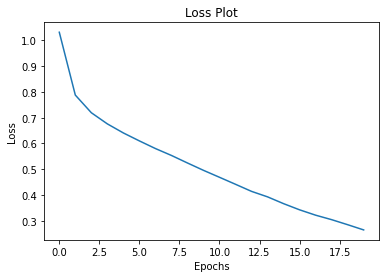

In [30]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

## Caption!

* The evaluate function is similar to the training loop, except you don't use teacher forcing here. The input to the decoder at each time step is its previous predictions along with the hidden state and the encoder output.<br>
評価関数は、ここで教師の強制を使用しないことを除いて、トレーニングループに似ています。各タイムステップでのデコーダーへの入力は、非表示状態およびエンコーダー出力と共に、以前の予測です。
* Stop predicting when the model predicts the end token.<br>
モデルが終了トークンを予測するときに予測を停止します。
* And store the attention weights for every time step.<br>
また、各タイムステップの注意の重みを保存します。

In [102]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [107]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(20, 20))

    len_result = len(result)
    for l in range(len_result):
        temp_att = np.resize(attention_plot[l], (8, 8))
        ax = fig.add_subplot(len_result//2, len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

Real Caption: <start> cars taxi truck van and a guy is on a motorcycle <end>
Prediction Caption: a person riding a blue bike with a couple on a sidewalk <end>


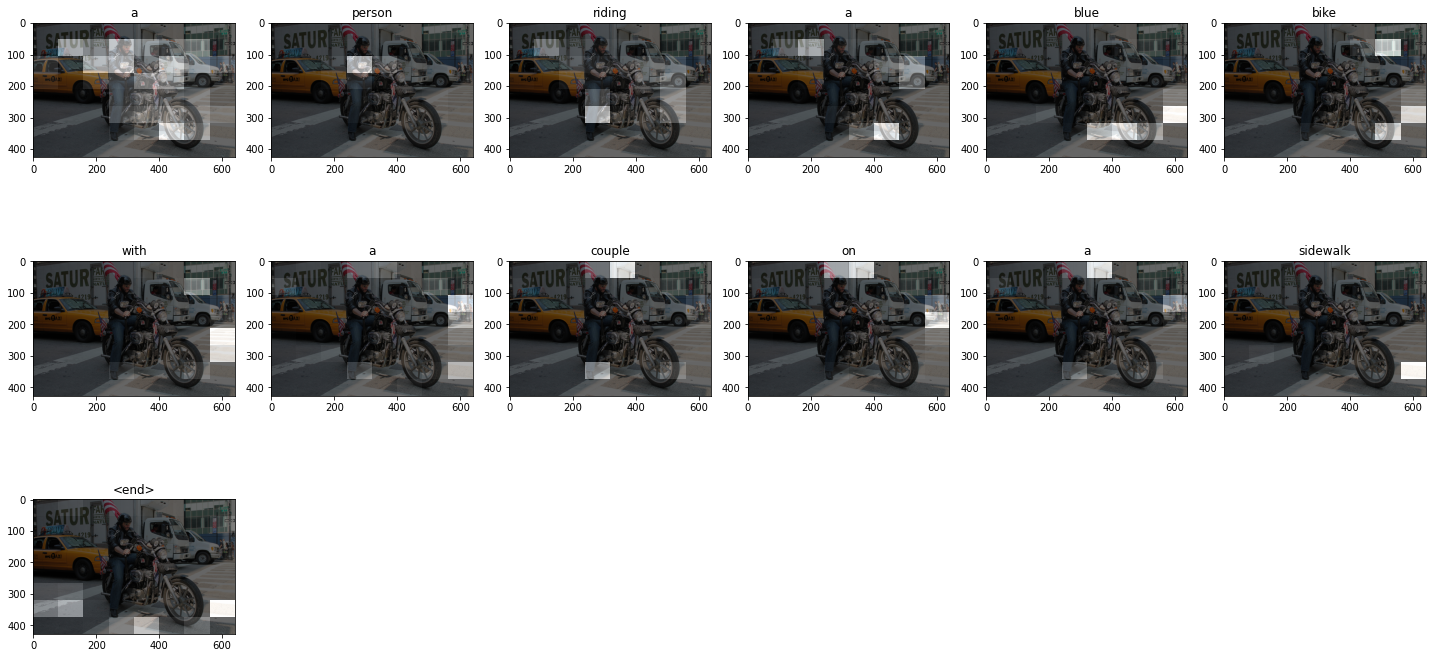

In [123]:
# captions on the validation set  #検証セットのキャプション
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

print ('Real Caption:', real_caption)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)


# 【問題2】（アドバンス課題）様々な手法を実行
TensorFLowやGoogle AI ResearchのGitHubリポジトリには、定番のモデルから最新のモデルまで多様なコードが公開されています。これらから興味あるものを選び実行してください。


なお、これらのコードは初学者向けではないため、巨大なデータセットのダウンロードが必要な場合など、実行が簡単ではないこともあります。そういった場合は、コードリーディングを行ってください。


models/research at master · tensorflow/models


google-research/google-research: Google AI Research


更新日が古いものはPythonやTensorFlowのバージョンが古く、扱いずらい場合があります。新しいものから見ることを推奨します。

## 回答無し

# 問題3】Iris（2値分類）をKerasで学習
TensorFlowによるIrisデータセットに対する2値分類をKerasに書き換えてください。

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from keras import backend as K

Using TensorFlow backend.
/Users/takahashihideyuki/.pyenv/versions/anaconda3-2019.10/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/takahashihideyuki/.pyenv/versions/anaconda3-2019.10/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/takahashihideyuki/.pyenv/versions/anaconda3-2019.10/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.

In [2]:
df = pd.read_csv("/Users/takahashihideyuki/dive/diveintocode-ml/Sprint_/datasets_19_420_Iris.csv", encoding="utf-8")

In [6]:
"""
TensorFlowで実装したIris2値分類をKerasに書き換える
"""
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers
# データセットの読み込み
dataset_path ="/Users/takahashihideyuki/dive/diveintocode-ml/Sprint_/datasets_19_420_Iris.csv"
df = pd.read_csv(dataset_path)
# データフレームから条件抽出
df = df[(df["Species"] == "Iris-versicolor")|(df["Species"] == "Iris-virginica")]
y = df["Species"]
X = df.loc[:, ["SepalLengthCm", "SepalWidthCm", "PetalLengthCm", "PetalWidthCm"]]
y = np.array(y)
X = np.array(X)
# ラベルを数値に変換
y[y=='Iris-versicolor'] = 0
y[y=='Iris-virginica'] = 1
y = y.astype(np.int)[:, np.newaxis]
# trainとtestに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
# さらにtrainとvalに分割
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

In [7]:
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.optimizers import Adam

K.clear_session()

model = Sequential()
model.add(Dense(50, activation='relu', input_dim=4))
model.add(Dense(100, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.weights

[<tf.Variable 'dense_1/kernel:0' shape=(4, 50) dtype=float32>,
 <tf.Variable 'dense_1/bias:0' shape=(50,) dtype=float32>,
 <tf.Variable 'dense_2/kernel:0' shape=(50, 100) dtype=float32>,
 <tf.Variable 'dense_2/bias:0' shape=(100,) dtype=float32>,
 <tf.Variable 'dense_3/kernel:0' shape=(100, 1) dtype=float32>,
 <tf.Variable 'dense_3/bias:0' shape=(1,) dtype=float32>]

In [8]:
model.compile(optimizer=tf.train.AdamOptimizer(learning_rate=0.01),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit(X_train, y_train, 
                epochs=10, 
                batch_size=10, 
                verbose=1,
                validation_data=(X_val, y_val))

test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print("test_acc : {:.3f}".format(test_acc))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 64 samples, validate on 16 samples
Epoch 1/10
64/64 [==============================] - 0s 2ms/step - loss: 0.9177 - accuracy: 0.4688 - val_loss: 0.7041 - val_accuracy: 0.3750
Epoch 2/10
64/64 [==============================] - 0s 249us/step - loss: 0.7300 - accuracy: 0.4688 - val_loss: 0.6840 - val_accuracy: 0.3750
Epoch 3/10
64/64 [==============================] - 0s 185us/step - loss: 0.6820 - accuracy: 0.5312 - val_loss: 0.7293 - val_accuracy: 0.3750
Epoch 4/10
64/64 [==============================] - 0s 154us/step - loss: 0.6462 - accuracy: 0.7344 - val_loss: 0.6292 - val_accuracy: 0.8750
Epoch 5/10
64/64 [==============================] - 0s 140us/step - loss: 0.6208 - accuracy: 0.8125 - val_loss: 0.6469 - val_accuracy: 0.3750
Epoch 6/10
64/64 [==============================] - 0s 220us/step - loss: 0.6116 - accuracy: 0.5781 - val_loss: 0.5542 - val_accuracy: 1.0000
Epoch 7/1

In [9]:
y_pred_proba = model.predict(X_train)[:, 0]
# 確率を0, 1に変換
y_pred = np.where(y_pred_proba >0.5, 1, 0)
print("y_pred_proba", y_pred_proba)
print("y_pred", y_pred)

y_pred_proba [0.9238287  0.26192927 0.8630837  0.18392542 0.8618723  0.40086013
 0.18363306 0.42272404 0.84338677 0.90107894 0.22817048 0.7955256
 0.45679164 0.7494339  0.69585955 0.26401073 0.6494695  0.8612722
 0.30489427 0.9086689  0.95911026 0.42873815 0.8063606  0.95725054
 0.91621494 0.41712517 0.9047372  0.1987614  0.88309646 0.92464745
 0.9389838  0.91489154 0.49436113 0.86385447 0.4324171  0.9732386
 0.93772995 0.18457231 0.25590533 0.61636597 0.12300527 0.7791576
 0.64166325 0.10094157 0.314205   0.47368282 0.9561381  0.9793465
 0.19017056 0.43013665 0.21045363 0.9303502  0.9326055  0.9596398
 0.95340145 0.8623433  0.38035217 0.90010303 0.7679633  0.9325336
 0.20856872 0.42203704 0.86788315 0.73424757]
y_pred [1 0 1 0 1 0 0 0 1 1 0 1 0 1 1 0 1 1 0 1 1 0 1 1 1 0 1 0 1 1 1 1 0 1 0 1 1
 0 0 1 0 1 1 0 0 0 1 1 0 0 0 1 1 1 1 1 0 1 1 1 0 0 1 1]


# 【問題4】Iris（多値分類）をKerasで学習
TensorFlowによるIrisデータセットに対する3値分類をKerasに書き換えてください。

In [10]:
"""
TensorFlowで実装したIris多値分類をKerasに書き換える
"""
# データセットの読み込み
dataset_path ="/Users/takahashihideyuki/dive/diveintocode-ml/Sprint_/datasets_19_420_Iris.csv"
df = pd.read_csv(dataset_path)
# データフレームから条件抽出
y = df["Species"]
X = df.loc[:, ["SepalLengthCm", "SepalWidthCm", "PetalLengthCm", "PetalWidthCm"]]
y = np.array(y)
X = np.array(X)
# ラベルを数値に変換
y[y=='Iris-setosa'] = 0 #Iris-setosaを追加
y[y=='Iris-versicolor'] = 1
y[y=='Iris-virginica'] = 2
y = y.astype(np.int) #[:, np.newaxis]
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y = enc.fit_transform(y[:, np.newaxis]) #one-hot処理
# trainとtestに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
# さらにtrainとvalに分割
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

In [11]:
K.clear_session()

model = Sequential()
model.add(Dense(50, activation='relu', input_dim=4))
model.add(Dense(100, activation='relu'))
model.add(Dense(3, activation='softmax'))
model.weights

[<tf.Variable 'dense_1/kernel:0' shape=(4, 50) dtype=float32>,
 <tf.Variable 'dense_1/bias:0' shape=(50,) dtype=float32>,
 <tf.Variable 'dense_2/kernel:0' shape=(50, 100) dtype=float32>,
 <tf.Variable 'dense_2/bias:0' shape=(100,) dtype=float32>,
 <tf.Variable 'dense_3/kernel:0' shape=(100, 3) dtype=float32>,
 <tf.Variable 'dense_3/bias:0' shape=(3,) dtype=float32>]

In [12]:
model.compile(optimizer=tf.train.AdamOptimizer(learning_rate=0.01),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit(X_train, y_train, 
                epochs=10, 
                batch_size=10, 
                verbose=1,
                validation_data=(X_val, y_val))

test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print("test_acc : {:.3f}".format(test_acc))

Train on 96 samples, validate on 24 samples
Epoch 1/10
96/96 [==============================] - 0s 820us/step - loss: 0.7744 - accuracy: 0.6458 - val_loss: 0.5543 - val_accuracy: 0.6250
Epoch 2/10
96/96 [==============================] - 0s 166us/step - loss: 0.4650 - accuracy: 0.7396 - val_loss: 0.3914 - val_accuracy: 0.7500
Epoch 3/10
96/96 [==============================] - 0s 141us/step - loss: 0.2876 - accuracy: 0.8854 - val_loss: 0.4087 - val_accuracy: 0.7083
Epoch 4/10
96/96 [==============================] - 0s 177us/step - loss: 0.2394 - accuracy: 0.9167 - val_loss: 0.3191 - val_accuracy: 0.7917
Epoch 5/10
96/96 [==============================] - 0s 142us/step - loss: 0.1639 - accuracy: 0.9062 - val_loss: 0.2486 - val_accuracy: 0.8333
Epoch 6/10
96/96 [==============================] - 0s 183us/step - loss: 0.1369 - accuracy: 0.9271 - val_loss: 0.2359 - val_accuracy: 0.8333
Epoch 7/10
96/96 [==============================] - 0s 147us/step - loss: 0.1455 - accuracy: 0.9271 - va

# 【問題5】House PricesをKerasで学習
TensorFlowによるHouse Pricesデータセットに対する回帰をKerasに書き換えてください。

In [13]:
dataset_path ="/Users/takahashihideyuki/dive/diveintocode-ml/Sprint_/train.csv"
df = pd.read_csv(dataset_path)

In [14]:
"""
TensorFlowで実装した回帰問題のデータセットであるHouse Pricesを使用したモデルをKerasに書き換える
"""
# データセットの読み込み
dataset_path ="/Users/takahashihideyuki/dive/diveintocode-ml/Sprint_/train.csv"
df = pd.read_csv(dataset_path)
# データフレームから条件抽出
y = df["SalePrice"]
X = df[["GrLivArea", "YearBuilt"]]
y = np.array(y)
X = np.array(X)

# 目的変数を対数変換
y = np.log1p(y).reshape(-1, 1)

#説明変数を標準化
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

# trainとtestに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
# さらにtrainとvalに分割
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

In [15]:
K.clear_session()

model = Sequential()
model.add(Dense(50, activation='relu', input_dim=2))
model.add(Dense(100, activation='relu'))
model.add(Dense(1))

model.compile(optimizer='Adam', loss='mse')

In [16]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 50)                150       
_________________________________________________________________
dense_2 (Dense)              (None, 100)               5100      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
Total params: 5,351
Trainable params: 5,351
Non-trainable params: 0
_________________________________________________________________


In [17]:
model.fit(X_train, y_train, 
                epochs=10, 
                batch_size=10, 
                verbose=1,
                validation_data=(X_val, y_val))

test_mse = model.evaluate(X_test, y_test, verbose=0)
print("test_mse : {:.3f}".format(test_mse))

Train on 934 samples, validate on 234 samples
Epoch 1/10
934/934 [==============================] - 0s 219us/step - loss: 92.0656 - val_loss: 18.1931
Epoch 2/10
934/934 [==============================] - 0s 106us/step - loss: 9.5904 - val_loss: 5.1193
Epoch 3/10
934/934 [==============================] - 0s 93us/step - loss: 5.1703 - val_loss: 3.0398
Epoch 4/10
934/934 [==============================] - 0s 99us/step - loss: 3.0285 - val_loss: 1.7970
Epoch 5/10
934/934 [==============================] - 0s 92us/step - loss: 1.8153 - val_loss: 1.0439
Epoch 6/10
934/934 [==============================] - 0s 98us/step - loss: 1.0775 - val_loss: 0.6645
Epoch 7/10
934/934 [==============================] - 0s 97us/step - loss: 0.6789 - val_loss: 0.3819
Epoch 8/10
934/934 [==============================] - 0s 92us/step - loss: 0.4122 - val_loss: 0.2718
Epoch 9/10
934/934 [==============================] - 0s 102us/step - loss: 0.2698 - val_loss: 0.1578
Epoch 10/10
934/934 [===================

# 【問題6】MNISTをKerasで学習
TensorFlowによるMNISTデータセットによる画像の多値分類をKerasに書き換えてください。

In [18]:
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

#入力データ（説明変数）を4次元にreshape
X_train = X_train.reshape(60000, 28, 28, 1)
X_test = X_test.reshape(10000, 28, 28, 1)

#正規化
X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255

#one-hot
# from sklearn.preprocessing import OneHotEncoder
# enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
# y_train = enc.fit_transform(y_train[:, np.newaxis])
# y_test = enc.fit_transform(y_test[:, np.newaxis])

# さらにtrainとvalに分割
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

In [19]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D

K.clear_session()

model = Sequential()
model.add(Conv2D(50, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(100, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(10, activation='softmax'))
model.weights

[<tf.Variable 'conv2d_1/kernel:0' shape=(3, 3, 1, 50) dtype=float32>,
 <tf.Variable 'conv2d_1/bias:0' shape=(50,) dtype=float32>,
 <tf.Variable 'conv2d_2/kernel:0' shape=(3, 3, 50, 100) dtype=float32>,
 <tf.Variable 'conv2d_2/bias:0' shape=(100,) dtype=float32>,
 <tf.Variable 'dense_1/kernel:0' shape=(2500, 10) dtype=float32>,
 <tf.Variable 'dense_1/bias:0' shape=(10,) dtype=float32>]

In [20]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 50)        500       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 50)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 100)       45100     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 100)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2500)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                25010     
Total params: 70,610
Trainable params: 70,610
Non-trainable params: 0
__________________________________________________

In [21]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(X_train, y_train,
                epochs=10, 
                batch_size=20, 
                verbose=1,
                validation_data=(X_val, y_val))

Train on 48000 samples, validate on 12000 samples
Epoch 1/10
48000/48000 [==============================] - 45s 928us/step - loss: 0.1378 - accuracy: 0.9580 - val_loss: 0.0482 - val_accuracy: 0.9846
Epoch 2/10
48000/48000 [==============================] - 56s 1ms/step - loss: 0.0483 - accuracy: 0.9853 - val_loss: 0.0426 - val_accuracy: 0.9869
Epoch 3/10
48000/48000 [==============================] - 60s 1ms/step - loss: 0.0333 - accuracy: 0.9897 - val_loss: 0.0413 - val_accuracy: 0.9866
Epoch 4/10
48000/48000 [==============================] - 60s 1ms/step - loss: 0.0240 - accuracy: 0.9923 - val_loss: 0.0378 - val_accuracy: 0.9884
Epoch 5/10
48000/48000 [==============================] - 60s 1ms/step - loss: 0.0177 - accuracy: 0.9944 - val_loss: 0.0368 - val_accuracy: 0.9887
Epoch 6/10
48000/48000 [==============================] - 60s 1ms/step - loss: 0.0144 - accuracy: 0.9951 - val_loss: 0.0434 - val_accuracy: 0.9883
Epoch 7/10
48000/48000 [==============================] - 59s 1ms/

In [22]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print("test_acc : {:.3f}".format(test_acc))

test_acc : 0.991


# 【問題7】（アドバンス課題）PyTorchへの書き換え
4種類の問題をPyTorchに書き換えてください。

## 回答無し

# 【問題8】（アドバンス課題）フレームワークの比較
それぞれのフレームワークにはどのような違いがあるかをまとめてください。

《視点例》

- 計算速度
  PyTorchの方がKerasより早い
- コードの行数・可読性
  Kerasの方がシンプルに記述でき、可読性は高い
- 用意されている機能<br>
  Pytorch:
  transform機能。入力が画像の場合、「リサイズ、画像読み込み、画素を正規化」というような前処理があるが、transform では、この一連の流れを配列の中に列挙することで一括して処理ができる。<br>
  Keras:
  model.fitで学習可能